In [26]:
from skimage import feature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
from pathlib import Path
import sys
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report, average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
import tensorflow as tf

In [27]:
parent_folder = Path().resolve().parent
src_path = parent_folder / 'src'
sys.path.append(str(src_path))
from tools import get_embedding_pyAudio, get_embedding_birdnet

In [28]:
parent_folder = Path().resolve().parent.parent
sys.path.append(str(parent_folder))
#from pyAudioAnalysis import MidTermFeatures as mT 

Combine BirdNet embeddings and pyAudioAnalysis embeddings

In [29]:
root_folder='C:/Users/dgnhk/Woodcock-CNN/data/train_data/embedding/'
audio_folder='C:/Users/dgnhk/Woodcock-CNN/data/train_data/audio/'

In [30]:
# Sample line for extracting features
#mT.mid_feature_extraction_file_dir(audio_folder+'1/', 3.0, 3.0, 0.2, 0.2)
#mT.mid_feature_extraction_file_dir(audio_folder+'0/', 3.0, 3.0, 0.2, 0.2)

In [31]:
pos_embeddings_birdnet = get_embedding_birdnet(root_folder, 1)
neg_embeddings_birdnet = get_embedding_birdnet(root_folder, 0)

In [32]:
pos_embeddings = get_embedding_pyAudio(audio_folder, 1)
neg_embeddings = get_embedding_pyAudio(audio_folder, 0)


In [33]:
df_pos = pd.DataFrame(data=pos_embeddings)
df_neg = pd.DataFrame(data=neg_embeddings)

df_pos_bnet = pd.DataFrame(data=pos_embeddings_birdnet)
df_neg_bnet = pd.DataFrame(data=neg_embeddings_birdnet)


df_pos_comb = pd.concat([df_pos, df_pos_bnet], ignore_index=True, axis=1)
df_neg_comb = pd.concat([df_neg, df_neg_bnet], ignore_index=True, axis=1)


In [34]:
df_pos

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,0.114818,0.048354,3.294780,0.252788,0.279335,0.768557,0.000386,0.113139,-19.124974,1.901674,...,0.004314,0.004842,0.006972,0.003609,0.008340,0.003913,0.005236,0.010063,0.008272,0.001372
1,0.115061,0.061572,3.293137,0.252653,0.279365,0.778544,0.000369,0.117486,-18.780366,1.868929,...,0.005803,0.003252,0.008139,0.009949,0.005139,0.007228,0.009016,0.013123,0.008390,0.002968
2,0.114852,0.054686,3.291873,0.252577,0.278228,0.793941,0.000387,0.119778,-18.975231,1.881596,...,0.006495,0.007241,0.009466,0.009266,0.002597,0.005544,0.008291,0.015118,0.012008,0.002683
3,0.119894,0.016910,3.275986,0.247073,0.268385,0.903414,0.000388,0.141069,-20.595653,1.704631,...,0.005381,0.007400,0.004599,0.007804,0.005315,0.005203,0.006283,0.009947,0.006477,0.001966
4,0.120103,0.020362,3.285445,0.251256,0.271568,0.883694,0.000390,0.146625,-20.364138,1.845879,...,0.005250,0.005772,0.003976,0.008079,0.004606,0.005276,0.007324,0.010330,0.012348,0.002343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,0.072244,0.032330,3.278622,0.168880,0.233184,0.287303,0.000713,0.081653,-20.330978,0.435935,...,0.008110,0.003705,0.002356,0.003465,0.001762,0.001379,0.004089,0.006599,0.002675,0.001276
804,0.091037,0.020715,3.248811,0.214593,0.266161,0.531639,0.000583,0.095014,-20.771972,1.208847,...,0.007021,0.004222,0.002721,0.004101,0.002322,0.007275,0.008361,0.023416,0.018983,0.005091
805,0.127013,0.024299,3.208457,0.276917,0.291059,0.933813,0.000504,0.134194,-20.971228,1.826228,...,0.013482,0.004171,0.008642,0.008084,0.005585,0.006157,0.010279,0.026856,0.012810,0.005781
806,0.110755,0.047393,3.247752,0.280815,0.305874,0.570589,0.000548,0.060042,-20.152100,2.313070,...,0.017568,0.010854,0.005994,0.013178,0.006627,0.004562,0.033184,0.015906,0.017458,0.005301


In [35]:
df_neg_comb['target'] = 0
df_pos_comb['target'] = 1

In [36]:
df_combined = pd.concat([df_pos_comb, df_neg_comb], ignore_index=True, axis=0)
df_combined = df_combined.sample(frac=1, random_state=42)

In [37]:
df_combined	= df_combined.dropna()

In [38]:
df_combined

,0,1,2,3,4,5,6,7,8,9,...,1151,1152,1153,1154,1155,1156,1157,1158,1159,target
1864,0.171157,0.027885,3.077316,0.215793,0.149225,1.408336,0.000611,0.265208,-24.666171,-0.467279,...,0.240940,0.649047,0.062604,0.000000,0.000000,0.000000,0.005312,0.117393,0.095469,0
1210,0.002861,0.091486,3.024466,0.066444,0.172137,0.004188,0.012497,0.002556,-25.802829,2.761781,...,0.029666,0.000000,0.036873,0.580463,0.277056,0.569529,1.364095,0.000000,0.617940,0
1924,0.170101,0.024609,3.151524,0.231949,0.164167,1.312884,0.000637,0.278111,-24.977336,0.124302,...,0.371436,0.395110,0.000000,0.370154,0.002111,0.000000,0.172139,0.207216,0.002635,0
1752,0.085023,0.011268,2.920734,0.165190,0.190889,0.920145,0.001006,0.131764,-23.806708,0.268551,...,0.336802,0.066970,0.275636,0.354362,1.181251,0.064648,0.261986,0.346249,0.145890,0
1095,0.100253,0.031328,3.175256,0.171567,0.186855,1.032892,0.001307,0.150667,-22.873019,0.286432,...,0.019306,0.000000,0.186795,0.041659,0.333879,0.340606,1.529553,0.183717,1.193724,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,0.049047,0.056490,3.197479,0.175646,0.255477,0.152255,0.001245,0.057097,-19.950493,1.226914,...,0.255451,0.311944,0.000000,0.030941,0.512110,0.000000,0.138062,0.279318,0.763271,0
3444,0.127034,0.020201,2.951613,0.205376,0.227356,0.750940,0.002012,0.154139,-22.843312,0.359866,...,0.232033,0.260655,0.066088,0.038308,0.000000,0.145350,0.801439,0.000000,0.674466,0
466,0.175782,0.022244,3.097028,0.229901,0.152312,1.328312,0.000663,0.277361,-25.381535,-0.140983,...,0.392205,0.749548,0.022669,0.000000,0.000000,0.000000,0.128671,0.000392,0.401801,1
3092,0.048922,0.047294,3.201106,0.166009,0.248670,0.120061,0.001183,0.063278,-20.438055,1.064152,...,0.000000,0.312309,0.145757,0.400617,0.495547,0.068687,0.885280,0.167556,0.973022,0


In [39]:
#Generate Test and Train datasets
X = df_combined.iloc[:, :-1] #All values except the last column
y = df_combined.iloc[:, -1] #All values from the last column

train, test, train_target, test_target = train_test_split(X, y, test_size=0.20, random_state=42)

In [40]:
class Config_Sampling:
    oversample = True #equals to B_SMOTE
    undersample = False
    sample_name = "UNDEFINED_SAMPLE"

oversampler = SMOTE()
undersampler = RandomUnderSampler()

if Config_Sampling.oversample:
    train, train_target = oversampler.fit_resample(train, train_target)
elif Config_Sampling.undersample:
    train, train_target = undersampler.fit_resample(train, train_target)
else: 
    print("Using the original dataset")

In [41]:
Train_Advanced_CNN = True #Trains the simple CNN

c:\Users\dgnhk\anaconda3\envs\yevhenii\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\dgnhk\anaconda3\envs\yevhenii\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1158, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 578, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 576, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 287, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 520)            │     2,388,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 260)            │       135,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 80)             │        20,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           162 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,542 (9.71 MB)

 Trainable params: 2,546,542 (9.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/29
421/421 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7108 - loss: 0.5274 - val_accuracy: 0.8153 - val_loss: 0.3850
Epoch 2/29
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9095 - loss: 0.2208 - val_accuracy: 0.9091 - val_loss: 0.2518
Epoch 3/29
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9464 - loss: 0.1402 - val_accuracy: 0.9033 - val_loss: 0.2610
Epoch 4/29
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9565 - loss: 0.1053 - val_accuracy: 0.9120 - val_loss: 0.2169
Epoch 5/29
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9745 - loss: 0.0667 - val_accuracy: 0.9091 - val_loss: 0.2566
Epoch 6/29
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9792 - loss: 0.0529 - val_accuracy: 0.9235 - val_loss: 0.3418
Epoch 7/29
421/421 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9879 - loss: 0.0331 - val_accuracy: 0.9307 - val_loss: 0.2994
Epoch 8/29
421/421 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9928 - loss: 0.0191 - val_accuracy

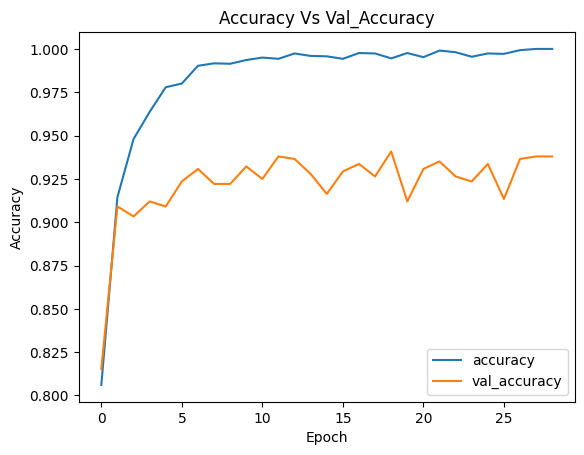

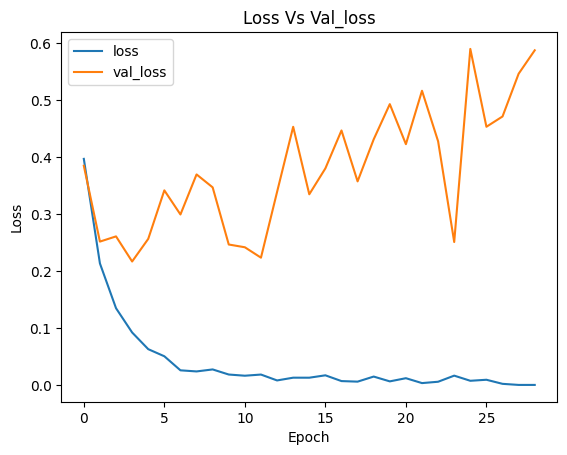

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0     0.9486    0.9745    0.9614       549
           1     0.8915    0.7986    0.8425       144

    accuracy                         0.9380       693
   macro avg     0.9200    0.8866    0.9019       693
weighted avg     0.9367    0.9380    0.9367       693

EVERYTHING FINISHED FOR ADVANCED CNN MODEL!


In [42]:
if Train_Advanced_CNN == True:
    class Config_Advanced_CNN:
        epochs = 29 #70 is default (exp1)
        batch_size = 10 #10 is default (exp1)
        exp_name = 42 #Experiment Number counter 
        patience = 70 #10 # is default (exp1)
        initial_learning_rate=0.0005 #Default Initial Learning Rate for ADAM: 0.001
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        reduce_lr_every_10_epochs = True #Reduce the learning rate each 10 Epochs with the rate defined below. Default is False for exp1.
        lr_reduction_rate = 0.5 # Reduction Rate for reducing each 10 epochs. 0.5 means, that lr is halfed each 10 epochs.
        Conv1_filter_num = 32 # Number of filters in the convolutional layer (more means more shape-variations can be detected) 
        Conv1_filter_size = 3 # Size (e.g. 3 by 3) of single convolutional kernel. More means a more rough approach to detection of patterns.
        filepath_checkpoint = '../models/DL_Models/Advanced_CNN/experiment_'+str(exp_name) + '_'+str (Config_Sampling.sample_name) +'.weights.h5'
        filepath_accuracy_plot = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+ str (Config_Sampling.sample_name) +'.accuracy_plot.png'
        filepath_loss_plot = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.loss_plot.png'
        filepath_classification_report = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.classification_report.txt'

    #Model structure: This is not changed during experiments.
    adv_cnn_model = tf.keras.models.Sequential()
    adv_cnn_model.add(tf.keras.layers.Conv1D(Config_Advanced_CNN.Conv1_filter_num, Config_Advanced_CNN.Conv1_filter_size, activation='relu', input_shape=(1160, 1))) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.Conv1D(Config_Advanced_CNN.Conv1_filter_num//2, Config_Advanced_CNN.Conv1_filter_size, activation='relu' )) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.Flatten()) # After  
    adv_cnn_model.add(tf.keras.layers.Dropout(rate=0.2))
    adv_cnn_model.add(tf.keras.layers.Dense(520, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(260, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(80, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    #Function for the learning rate scheduler
    def lr_scheduler(epoch, lr):
        if Config_Advanced_CNN.reduce_lr_every_10_epochs and epoch % 10 == 0: # %10 == 0 means each 10 epochs (only then no "rest" after dividing trough 10)
            return lr * Config_Advanced_CNN.lr_reduction_rate  # reduce the learning rate with the configured rate
        else:
            return lr

    # callback for the learning rate reduction schedule (function)
    lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    
    #Model checkpoint: Saves the best model for all epochs with regards to the validation accuracy. Only weights (.h5) are saved.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=Config_Advanced_CNN.filepath_checkpoint,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    #Early stop callback: If validation accuracy does not change during the last XXX epochs, training is stopped (XXX is configured as patience)
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=Config_Advanced_CNN.patience)

    #Compilation of model with ADAM and custom lr, sparse_categorical_crossentropy since we have integers as class labels.
    adv_cnn_model.compile(optimizer=Config_Advanced_CNN.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    adv_cnn_model.summary()

    
    """The following transformation of DataFrames to NumPy arrays and reshaping them is necessary to match the input requirements of the Convolutional Neural Network model.
     CNNs in TensorFlow typically expect input data in the form of NumPy arrays with specific shapes, especially when using Conv1D layers.
    This reshaping ensures that the data is in the correct format for training and inference."""
    train_array = train.to_numpy()
    test_array = test.to_numpy()
    train_reshaped = train_array.reshape(train_array.shape[0], train_array.shape[1], 1)
    test_reshaped = test_array.reshape(test_array.shape[0], test_array.shape[1], 1)
    
    #training the model and storing all results in training history. aside from the datasets, all arguments are called from our config-class. Also calling the respective callbacks.
    adv_cnn_model_history = adv_cnn_model.fit(train_reshaped, train_target, epochs=Config_Advanced_CNN.epochs, batch_size=Config_Advanced_CNN.batch_size, 
                                      validation_data=(test_reshaped, test_target), 
                                      callbacks=[model_checkpoint_callback, early_stop_callback])
    
    #some plots for early interpretion during the run
    plt.plot(adv_cnn_model_history.history['accuracy'])
    plt.plot(adv_cnn_model_history.history['val_accuracy'])
    plt.legend(["accuracy","val_accuracy"])
    plt.title(f'Accuracy Vs Val_Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(Config_Advanced_CNN.filepath_accuracy_plot)
    plt.show()
    plt.close()

    plt.plot(adv_cnn_model_history.history['loss'])
    plt.plot(adv_cnn_model_history.history['val_loss'])
    plt.legend(["loss","val_loss"])
    plt.title('Loss Vs Val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(Config_Advanced_CNN.filepath_loss_plot)
    plt.show()
    plt.close()

    #Predict on test set.
    predictions = adv_cnn_model.predict(test_reshaped).argmax(axis=1)

    #make classification report and save it directly as a file.
    report = classification_report(test_target, predictions, digits=4)
    print(report)
    with open(Config_Advanced_CNN.filepath_classification_report, 'w') as report_file:
        report_file.write(report)

    print("EVERYTHING FINISHED FOR ADVANCED CNN MODEL!")

else:
    print("ADVANCED CNN Model is not trained and evaluated")

Avg. Precision

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test set average precision: 0.7537871796592727
              precision    recall  f1-score   support

           0     0.9486    0.9745    0.9614       549
           1     0.8915    0.7986    0.8425       144

    accuracy                         0.9380       693
   macro avg     0.9200    0.8866    0.9019       693
weighted avg     0.9367    0.9380    0.9367       693



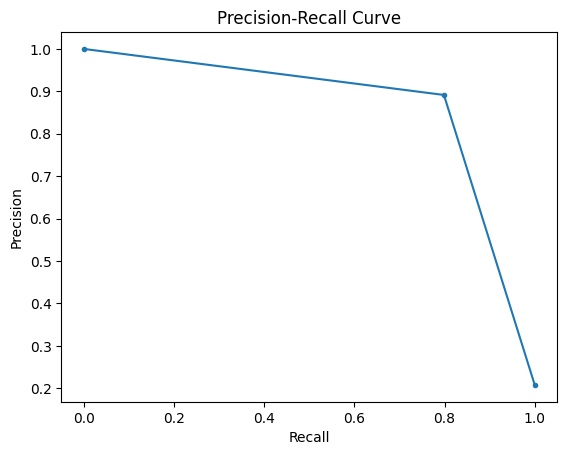

In [43]:
predictions = adv_cnn_model.predict(test_reshaped).argmax(axis=1)
ap = average_precision_score(test_target, predictions)
print("Test set average precision:", ap)

report=classification_report(test_target, predictions, digits=4)
print(report)

# Only for binary classification (adjust for multi-class)
precision, recall, thr = precision_recall_curve(test_target, predictions)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()